In [6]:
import os
import sys
import time 
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import nn_ops
from tensorflow.python.keras import initializers, regularizers, constraints
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input, Layer
from tensorflow.python.keras.layers.core import Activation, Reshape
from tensorflow.python.keras.layers.convolutional import Convolution2D, UpSampling2D
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.pooling import MaxPooling2D
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [7]:
# Define class for extracting time per epoch
class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

cb = TimingCallback()

In [8]:
# # # Dataset 1: Final abdomen images
# TRAIN_PATH1 = ['../allabdomen/train/skin_train2019/']
# MASK_PATH1 = ['../allabdomen/train/annotations/']
# train_ids1 = next(os.walk(TRAIN_PATH1[0]))[2]
# mask_ids1 = next(os.walk(MASK_PATH1[0]))[2]
# train_ids1.sort()
# mask_ids1.sort()
# TRAIN_PATH1 = TRAIN_PATH1*len(train_ids1)
# MASK_PATH1 = MASK_PATH1*len(train_ids1)

# # # Dataset 2: Augmented Abdomen Images
# TRAIN_PATH2 = ['../allabdomen/train/skin_augmented/']
# MASK_PATH2 = ['../allabdomen/train/annotations_augmented/']
# train_ids2 = next(os.walk(TRAIN_PATH2[0]))[2]
# mask_ids2 = next(os.walk(MASK_PATH2[0]))[2]
# train_ids2.sort()
# mask_ids2.sort()
# TRAIN_PATH2 = TRAIN_PATH2*len(train_ids2)
# MASK_PATH2 = MASK_PATH2*len(train_ids2)

# # # Combine everything
# TRAIN_PATH = np.concatenate((TRAIN_PATH1,TRAIN_PATH2))
# MASK_PATH = np.concatenate((MASK_PATH1,MASK_PATH2))
# train_ids = np.concatenate((train_ids1,train_ids2))
# mask_ids = np.concatenate((mask_ids1,mask_ids2))


# # Get and resize train images and masks DONT RUN IN THIS CODE
# X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
# print('Getting and resizing train images and masks ... ')
# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
#     path = TRAIN_PATH[n] + id_
#     img = imread(path)[:,:,:IMG_CHANNELS]
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_train[n] = img

# for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
#     path = MASK_PATH[n] + id_
#     img = imread(path)
#     #if n in range(899,977):
#         #img = img[:,:,1]
#     img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                                       preserve_range=True), axis=-1)
#     Y_train[n] = img
# # Saving the Loaded train np arrays
# np.save('X_train.npy',X_train)
# np.save('Y_train.npy',Y_train)

Getting and resizing train images and masks ... 


In [9]:
# Loading the Training and Testing Data
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')

In [24]:
# len(X_train)
len(Y_train)

4536

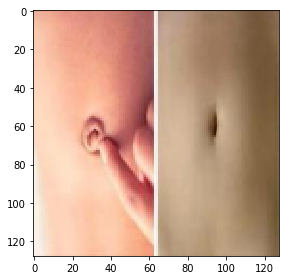

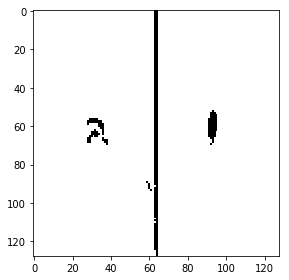

In [21]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [26]:
# Build SEGNET model
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
n_labels = 2
output_mode = "softmax"

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Encoder

conv_1 = Convolution2D(64, (3, 3), kernel_initializer='he_normal', padding="same")(inputs)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Activation("relu")(conv_1)
conv_2 = Convolution2D(64, (3, 3), kernel_initializer='he_normal', padding="same")(conv_1)
conv_2 = BatchNormalization()(conv_2)
conv_2 = Activation("relu")(conv_2)

pool_1 = MaxPooling2D((2, 2))(conv_2)

conv_3 = Convolution2D(128, (3, 3), kernel_initializer='he_normal', padding="same")(pool_1)
conv_3 = BatchNormalization()(conv_3)
conv_3 = Activation("relu")(conv_3)
conv_4 = Convolution2D(128, (3, 3), kernel_initializer='he_normal', padding="same")(conv_3)
conv_4 = BatchNormalization()(conv_4)
conv_4 = Activation("relu")(conv_4)

pool_2 = MaxPooling2D((2,2))(conv_4)

conv_5 = Convolution2D(256, (3, 3), kernel_initializer='he_normal', padding="same")(pool_2)
conv_5 = BatchNormalization()(conv_5)
conv_5 = Activation("relu")(conv_5)
conv_6 = Convolution2D(256, (3, 3), kernel_initializer='he_normal', padding="same")(conv_5)
conv_6 = BatchNormalization()(conv_6)
conv_6 = Activation("relu")(conv_6)
conv_7 = Convolution2D(256, (3, 3), kernel_initializer='he_normal', padding="same")(conv_6)
conv_7 = BatchNormalization()(conv_7)
conv_7 = Activation("relu")(conv_7)

pool_3 = MaxPooling2D((2,2))(conv_7)

conv_8 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(pool_3)
conv_8 = BatchNormalization()(conv_8)
conv_8 = Activation("relu")(conv_8)
conv_9 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(conv_8)
conv_9 = BatchNormalization()(conv_9)
conv_9 = Activation("relu")(conv_9)
conv_10 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(conv_9)
conv_10 = BatchNormalization()(conv_10)
conv_10 = Activation("relu")(conv_10)

pool_4 = MaxPooling2D((2,2))(conv_10)

conv_11 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(pool_4)
conv_11 = BatchNormalization()(conv_11)
conv_11 = Activation("relu")(conv_11)
conv_12 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(conv_11)
conv_12 = BatchNormalization()(conv_12)
conv_12 = Activation("relu")(conv_12)
conv_13 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(conv_12)
conv_13 = BatchNormalization()(conv_13)
conv_13 = Activation("relu")(conv_13)

pool_5 = MaxPooling2D((2,2))(conv_13)

# Decoder

unpool_1 = UpSampling2D((2,2))(pool_5)

conv_14 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(unpool_1)
conv_14 = BatchNormalization()(conv_14)
conv_14 = Activation("relu")(conv_14)
conv_15 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(conv_14)
conv_15 = BatchNormalization()(conv_15)
conv_15 = Activation("relu")(conv_15)
conv_16 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(conv_15)
conv_16 = BatchNormalization()(conv_16)
conv_16 = Activation("relu")(conv_16)

unpool_2 = UpSampling2D((2,2))(conv_16)

conv_17 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(unpool_2)
conv_17 = BatchNormalization()(conv_17)
conv_17 = Activation("relu")(conv_17)
conv_18 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(conv_17)
conv_18 = BatchNormalization()(conv_18)
conv_18 = Activation("relu")(conv_18)
conv_19 = Convolution2D(256, (3, 3), kernel_initializer='he_normal', padding="same")(conv_18)
conv_19 = BatchNormalization()(conv_19)
conv_19 = Activation("relu")(conv_19)

unpool_3 = UpSampling2D((2,2))(conv_19)

conv_20 = Convolution2D(256, (3, 3), kernel_initializer='he_normal', padding="same")(unpool_3)
conv_20 = BatchNormalization()(conv_20)
conv_20 = Activation("relu")(conv_20)
conv_21 = Convolution2D(256, (3, 3), kernel_initializer='he_normal', padding="same")(conv_20)
conv_21 = BatchNormalization()(conv_21)
conv_21 = Activation("relu")(conv_21)
conv_22 = Convolution2D(128, (3, 3), kernel_initializer='he_normal', padding="same")(conv_21)
conv_22 = BatchNormalization()(conv_22)
conv_22 = Activation("relu")(conv_22)

unpool_4 = UpSampling2D((2,2))(conv_22)

conv_23 = Convolution2D(128, (3, 3), kernel_initializer='he_normal', padding="same")(unpool_4)
conv_23 = BatchNormalization()(conv_23)
conv_23 = Activation("relu")(conv_23)
conv_24 = Convolution2D(64, (3, 3), kernel_initializer='he_normal', padding="same")(conv_23)
conv_24 = BatchNormalization()(conv_24)
conv_24 = Activation("relu")(conv_24)

unpool_5 = UpSampling2D((2,2))(conv_24)

conv_25 = Convolution2D(64, (3, 3), kernel_initializer='he_normal', padding="same")(unpool_5)
conv_25 = BatchNormalization()(conv_25)
conv_25 = Activation("relu")(conv_25)

conv_26 = Convolution2D(1, (1, 1), kernel_initializer='he_normal', padding="valid")(conv_25)
conv_26 = BatchNormalization()(conv_26)
# conv_26 = Reshape((128*128, 2), input_shape=(128, 128, 2))(conv_26)
outputs = Activation("softmax")(conv_26)

model = Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=30, verbose=1)
checkpointer = ModelCheckpoint('model-segnet-21Mar2019.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.20, batch_size=64, epochs=50, shuffle=True, 
                    callbacks=[earlystopper, checkpointer, cb])

Train on 3628 samples, validate on 908 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/50
3584/3628 [============================>.] - ETA: 12s - loss: 326.2588 - acc: 0.6802
Epoch 00001: val_loss improved from inf to 447.33963, saving model to model-segnet-21Mar2019.h5
3628/3628 [==============================] - 1064s 293ms/sample - loss: 324.6257 - acc: 0.6808 - val_loss: 447.3396 - val_acc: 0.5567
Epoch 2/50
3584/3628 [============================>.] - ETA: 12s - loss: 326.1204 - acc: 0.6804
Epoch 00002: val_loss did not improve from 447.33963
3628/3628 [==============================] - 1053s 290ms/sample - loss: 324.5830 - acc: 0.6808 - val_loss: 448.1123 - val_acc: 0.5567
Epoch 3/50
3584/3628 [============================>.] - ETA: 12s - loss: 326.2676 - acc: 0.6802
Epoch 00003: val_loss did not improve from 447.33963
3628/3628 [==============================] - 1056s 291ms/sample - los